In [1]:
import pandas as pd
import cluj_tools as ct

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

### Get Rosters

In [2]:
matchup_end_date, matchupPeriod = ct.matchup_end_date()

Matchup end date is 2020-02-23
Matchup period is 17


In [3]:
rosters = ct.get_rosters(matchupPeriod)

### Get Boxscore data to calculate octys

In [4]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%(AUTH['db_user'],AUTH['db_pass'],dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [5]:
sql = """
    SELECT * FROM boxscores b
    LEFT JOIN player_name_comparison c ON b.name = c.boxscore_name
    WHERE b.season_year = '2019-2020' AND b.season_type = 'regular'
"""

In [6]:
boxscores = pd.read_sql(sql, engine)
boxscores['ft_pct'] = boxscores.ftm / boxscores.fta
boxscores['fg_pct'] = boxscores.fgm / boxscores.fga

In [7]:
boxscores.loc[boxscores.espn_name.isnull(),'espn_name'] = boxscores.loc[boxscores.espn_name.isnull(),'name']

In [8]:
ft_pct_threshold = 0.75
fg_pct_threshold = 0.4
octys = boxscores.loc[(boxscores.assists > 0) & (boxscores.threes > 0) & (boxscores.steals > 0) & (boxscores.rebounds > 0) & (boxscores['blocks'] > 0) & (boxscores.ft_pct > ft_pct_threshold) & (boxscores.fg_pct > fg_pct_threshold)]
octys.shape

(436, 21)

In [9]:
octy_counts = pd.DataFrame(octys.espn_name.value_counts())
octy_counts.reset_index(inplace=True)
octy_counts.rename(columns={'espn_name':'octy_count', 'index':'espn_name'}, inplace=True)

In [10]:
octy_counts.head()

,espn_name,octy_count
0,Anthony Davis,14
1,James Harden,12
2,Kawhi Leonard,10
3,Joel Embiid,9
4,Brandon Ingram,8


In [11]:
octys_games = pd.DataFrame(boxscores.groupby('espn_name')['assists'].count())
octys_games.reset_index(inplace=True)
octys_games.rename(columns={'assists':'game_count'}, inplace=True)

In [12]:
merged = octy_counts.merge(octys_games, on='espn_name')
merged['octy_pct'] = merged.octy_count / merged.game_count
merged.sort_values('octy_pct', ascending=False, inplace=True)
merged.shape

(180, 4)

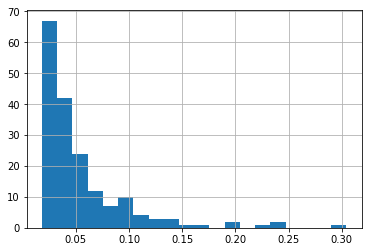

In [13]:
merged.octy_pct.hist(bins=20)

In [14]:
merged.head(30)

,espn_name,octy_count,game_count,octy_pct
0,Anthony Davis,14,46,0.304348
2,Kawhi Leonard,10,42,0.238095
1,James Harden,12,51,0.235294
3,Joel Embiid,9,39,0.230769
9,John Collins,6,30,0.200000
23,Kyrie Irving,4,20,0.200000
4,Brandon Ingram,8,47,0.170213
6,Pascal Siakam,7,44,0.159091
11,Josh Richardson,6,41,0.146341
5,Nikola Jokic,8,55,0.145455


In [15]:
rosters_merge = merged.merge(rosters, left_on='espn_name', right_on='fullName', how='left')
rosters_merge.shape

(180, 6)

In [16]:
rosters_merge.groupby('teamId')['octy_pct'].mean().sort_values()

teamId
1.0     0.050973
2.0     0.051938
9.0     0.054340
11.0    0.055796
12.0    0.056603
3.0     0.062995
6.0     0.066564
8.0     0.068552
10.0    0.070789
5.0     0.076822
7.0     0.077447
4.0     0.095874
Name: octy_pct, dtype: float64

In [17]:
rosters_merge.groupby('teamId')['octy_count'].sum().sort_values()

teamId
2.0     18
1.0     22
11.0    22
12.0    23
8.0     24
9.0     24
3.0     27
6.0     28
7.0     32
5.0     35
10.0    38
4.0     51
Name: octy_count, dtype: int64

In [18]:
rosters_merge.loc[rosters_merge.teamId == 10]

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
8,Josh Richardson,6,41,0.146341,Josh Richardson,10.0
9,Nikola Jokic,8,55,0.145455,Nikola Jokic,10.0
16,Myles Turner,5,45,0.111111,Myles Turner,10.0
24,Mikal Bridges,5,55,0.090909,Mikal Bridges,10.0
35,Miles Bridges,4,54,0.074074,Miles Bridges,10.0
76,Derrick Rose,2,45,0.044444,Derrick Rose,10.0
83,Giannis Antetokounmpo,2,48,0.041667,Giannis Antetokounmpo,10.0
86,Jeff Teague,2,48,0.041667,Jeff Teague,10.0
109,Justin Holiday,2,55,0.036364,Justin Holiday,10.0
122,Elfrid Payton,1,36,0.027778,Elfrid Payton,10.0


In [20]:
# should only be players on waiver wire
rosters_merge.loc[rosters_merge.fullName.isnull()].sort_values('octy_pct', ascending=False).head(20)

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
18,Kadeem Allen,1,10,0.100000,NaN,NaN
22,Jonathan Isaac,3,32,0.093750,NaN,NaN
26,Justise Winslow,1,11,0.090909,NaN,NaN
38,PJ Dozier,1,15,0.066667,NaN,NaN
41,Larry Nance Jr.,3,45,0.066667,NaN,NaN
45,Jabari Parker,2,32,0.062500,NaN,NaN
49,Josh Okogie,3,51,0.058824,NaN,NaN
52,Derrick White,3,52,0.057692,NaN,NaN
57,OG Anunoby,3,54,0.055556,NaN,NaN
58,Maxi Kleber,3,54,0.055556,NaN,NaN
